<a href="https://colab.research.google.com/github/lnpanh/CSC14116/blob/lnpanh/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FINAL REPORT

Course: Applied Parallel Programming

18127039 -  Lâm Ngọc Phương Anh

18127046 - Lư Ngọc Liên 

1653098 - Võ Minh Tú


# Enhancing Document Image

## Phát biểu bài toán




### Tổng quan


Enhacing document image là một bước trong công việc xử lý ảnh, là bước nền cơ bản hỗ trợ cho các chức năng nâng cao khác như scan hình ảnh, chuyển đổi ảnh thành text, điều chỉnh lại góc chụp của bức ảnh.

Một vài ứng dụng sử dụng bài toán này là:
- Chức năng scan ảnh trong ứng dụng Note của Iphone
- CamScanner

### Mô tả đầu ra và đầu vào của bài toán






* Đầu vào: một bức ảnh có góc chụp không trực diện với màn hình
* Đầu ra: Bức ảnh có góc chụp trực diện với màn hình (bỏ đi các background dư thừa)

![](https://i.imgur.com/8cfHARR.png)

*cre*: [dropbox.Tech, Jongmin Baek, Aug 16, 2016, Fast document rectification and enhancement](https://dropbox.tech/machine-learning/fast-document-rectification-and-enhancement)

### **Các bước thực hiện**
* Phát hiện biên cạnh
* Lấy viền của đối tượng dựa trên các cạnh đã xác định
* Đưa ảnh tài liệu về đối diện màn hình
* Điều chỉnh độ tương phản, độ sáng của bức ảnh

#### Bước 1: Phát hiện biên cạnh

https://minhng.info/tutorials/xu-ly-anh-opencv-hien-thuc-canny-edge.html

* Phát hiện biên cạnh là bước tìm ra các biên thuộc các đối tượng trong ảnh, nhầm phân tách và biết được hình dạng (shape) các đối tượng đó.
* Có 2 thuật toán nổi tiếng cho bài toán này là Sobel edge detector và Canny edge detector.
* Trong bài toán này nhóm xin chọn sử dụng thuật toán Canny edge detector. Thuật toán gồm 4 bước
    1. Giảm nhiễu: tiến hành làm mờ và giảm nhiễu cho bức ảnh bằng Gaussian ([Công thức của Gaussian Filter](https://docs.opencv.org/2.4/doc/tutorials/imgproc/gausian_median_blur_bilateral_filter/gausian_median_blur_bilateral_filter.html#gaussian-filter))
    2. Tình Gradient và hướng gradient: Sử dụng bộ lọc Sobel X và Sobel Y để lấy ra được đạo hàm theo chiều ngang (Gx) và dọc của bức ảnh (Gy). Từ đó ta sẽ tính được  gradient (độ lớn của sự biến đổi mức sáng ở vị trí pixel tương ứng với ảnh gốc) và hướng của từng pixel trong ảnh theo công thức sau. Trong đó hướng của cạnh được chia thành 4 hướng đại diện: ngang (0 độ), chéo bên phải (45 độ), dọc (90 độ), chéo bên trái (135 độ). 
  $$Edge\_Gradient(G) = \sqrt{G^2_x + G^2_y}$$

  $$Angle (Θ) = tan^{-1} (\frac{G_y}{G_x})$$
  3. Tính non-max suppression: Mục đích lọc bỏ các pixel không phải là cực đại cục bộ. Ta sử dụng 1 filter 3x3 chạy lần lượt qua các pixel của ảnh sau khi đã gradient. Trong các lần chạy, ta xét độ lớn của pixel hiện tại có phải là cực đại so với 2 hàng xóm (dựa trên hướng gradient)  hay không. Nếu là cực đại thì ghi nhận lại pixel đó, ngược lại set độ lớn của pixel đó bằng 0.
  4. Lọc ngưỡng: ở đây ta có 2 giá trị được gọi là maxVal và minVal. Nếu pixel hiện tại có giá trị lớn hơn maxVal thì pixel đó là cạnh, nhỏ hơn minVal thì bị loại bỏ. Còn các pixel nằm giữa maxVal và minVal, ta sẽ xét nó nằm gần với bên nào để quyết định có giữ lại nó hay không. 



* **Có nên tăng tốc giai đoạn xử lý ảnh này không? Tại sao? Và nếu cần tăng tốc thì có thể áp dụng lập trình song song vào không?**
    * **Nên** Thời gian để nhân tích chấp có thể khá lâu nếu bức ảnh có kích thước lớn. 
    * Có thể áp dụng lập trình song song vào ở các bước 1 và bước tính gradient của bước 2 vì các pixel sẽ được tính toán một cách độc lập.

#### Bước 3: Đưa ảnh tài liệu về đối diện màn hình


* Lúc này, ta sẽ lấy các pixel nằm bên trong viền đã được nhận diện ở bước trước đó, thực hiện việc map các điểm ảnh này sang một không gian tọa độ mới (đối diện màn hình).

* Các hướng tiếp cận cho bước có điểm chung là đều được thực hiện bằng cách nhân ma trận trên một hệ tọa độ đồng nhất ([Homogeneous coordinates](https://en.wikipedia.org/wiki/Homogeneous_coordinates)):

    * Sử dụng các **phép xoay ảnh**: Xoay bức ảnh quanh một điểm theo một góc xác định nào đó, vẫn giữ nguyên các tính chất của ảnh (các góc của ảnh vẫn giữ nguyên).
    * Sử dụng phép biến đổi affine: Cần xác định ba điểm trên ảnh gốc và vị trí của chúng trên ảnh kết quả. Biến đổi affine giúp tạo ra nhiều tư thế, biến thể khác nhau của vật thể. Các biến thể này sẽ được bảo toàn tính song song, tỉ lệ khoảng cách của vật thể và các đường thẳng trong ảnh.
    * Sử dụng biến đổi phối cảnh (Perspective transform hoặc Homography transform): Đây là một phép biến đổi đặc biệt khi mà ảnh kết quả không được đảm bảo về góc, độ dài, tính song song so với ảnh gốc ngoại trừ bảo toàn đường thẳng.


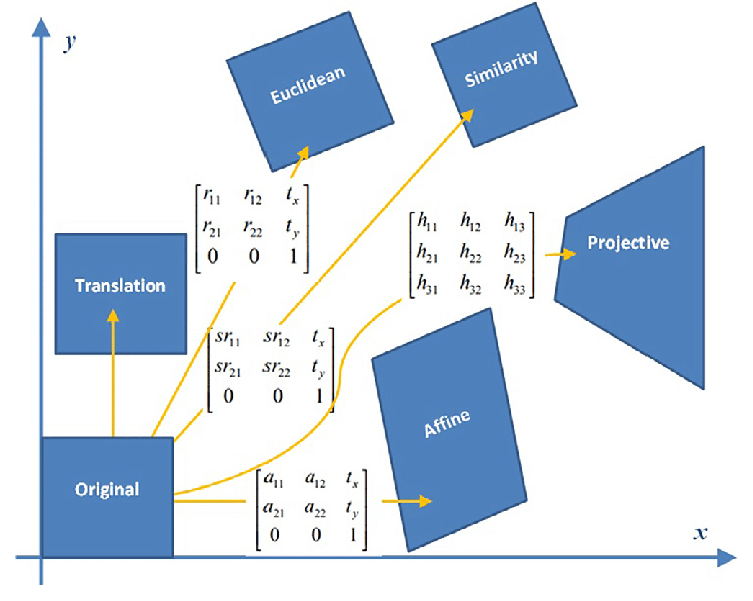

cre: A. Soycan - Metin Soycan (2018), Perspective correction of building facade images for architectural applications. Engineering Science and Technology an International Journal 22(3).

##### **Phép biến đổi Homography**

* Đối với bài toán này, hình dạng của văn bản trong ảnh đầu vào đa dạng và không phải luôn là chữ nhật $→$ **biến đổi phối cảnh** sẽ là giải pháp tốt nhất để có thể đưa văn bản về đối diện màn hình.

* Các bước thực hiện phép biến đổi Homography:
    1. Xác định 4 điểm góc của văn bản trong ảnh đầu vào (source points) và xem nó là 4 đỉnh của ảnh đầu ra (target points).
    2. Dựa trên 4 điểm đã chọn, tính chiều dài và rộng cho ảnh đầu ra $→$ xác định được tọa độ 4 đỉnh trong không gian mới và kích thước của ảnh output.
    3. Khi đã có được source và target points thì ta có thể dễ dàng tính được ma trận biến đổi **H** (3x3).
    4. Thực hiện việc chuyển đổi tọa độ cho từng điểm ảnh bằng công thức sau:
    $$dst(x,y) = src(\frac{H_{0,0}x + H_{0,1}y + H_{0,2}}{H_{2,0}x + H_{2,1}y + H_{2,2}},\frac{H_{1,0}x + H_{1,1}y + H_{1,2}}{H_{2,0}x + H_{2,1}y + H_{2,2}})$$ 


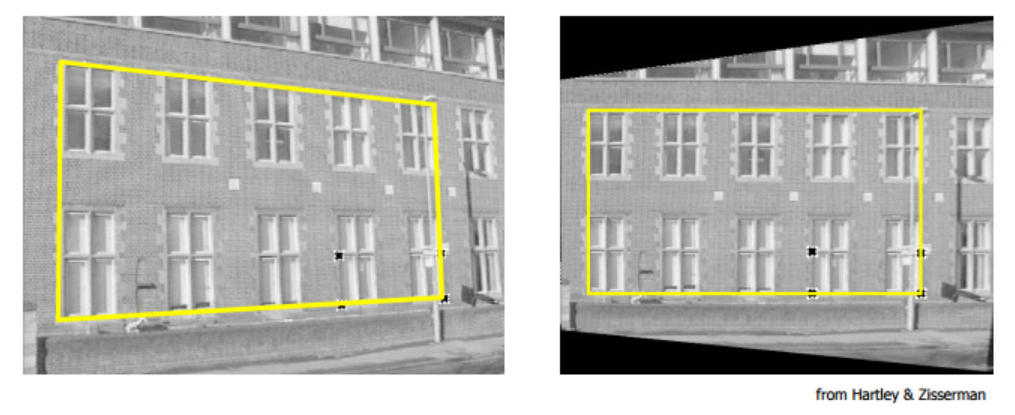

cre: [OpenCV, Basic concepts of the homography explained with code.](https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html)

* **Có nên tăng tốc giai đoạn xử lý ảnh này không? Tại sao? Và nếu cần tăng tốc thì có thể áp dụng lập trình song song vào không?**
    * **Nên** vì có thể thấy tại bước 4 của quá trình này là việc xác định tọa độ mới của từng pixel, điều này có thể sẽ tốn nhiều thời gian khi kích thước bức ảnh lớn.
    * Có thể áp dụng lập trình song song vào **bước 4** vì các pixel sẽ được tính toán một cách độc lập.

#### Bước 4: Điều chỉnh độ tương phản, độ sáng của bức ảnh

* Điều chỉnh độ sáng, độ tương phản của bức ảnh sau khi đã đưa ảnh tài liệu về chính diện màn hình.
* Lúc này ta sẽ sử dụng công thức với 2 quy trình điểm thường được sử dụng là nhân và cộng với một hằng số: 

>>      g (x) = αf (x) + β

* Các tham số α> 0 và β thường được gọi là 
gain and bias parameters, đôi khi các thông số này được cho là để kiểm soát độ tương phản và độ sáng tương ứng.

* Ta có thể coi f(x) là các pixel của ảnh đầu vào và g(x) là các pixel của ảnh đầu ra.

* Chúng ta có thể viết cho dể hình dung:

>>     g (i, j) = α⋅f (i, j) + β

* Trong đó i và j là pixel nằm ở hàng thứ i và cột thứ j.















* **Có nên tăng tốc giai đoạn xử lý ảnh này không? Tại sao? Và nếu cần tăng tốc thì có thể áp dụng lập trình song song vào không?**
    * **Nên** vì có thể thấy tại bước này của quá trình là việc xác định và tiếp cận  từng pixel của 3 kênh màu của ảnh là RGB, điều này có thể sẽ tốn nhiều thời gian khi kích thước bức ảnh lớn.
    * Có thể áp dụng lập trình song song vào **bước 4** vì các pixel sẽ được tính toán một cách độc lập.

## Code

### Khai báo thư viện + đọc ảnh đầu vào

Các phần sử dụng hàm của OpenCV :
-  [Canny edge detection](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123?fbclid=IwAR0e9rtoffrqAwTEx9bc8TzpX3y0bgx3UcDRkJR_njyENCY8heaObum6Nks)

- [Find coutours](https://stackoverflow.com/questions/62039403/python-opencv-finding-the-biggest-contour)

- [Homography](https://pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/)

In [ ]:
import numpy as np
from numba import *
from PIL import *
import requests
from io import BytesIO
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
import math

from skimage.filters import threshold_local

from google.colab.patches import cv2_imshow
import imutils

import warnings
warnings.filterwarnings('ignore')

In [ ]:
img_path = '/content/poster.png'
img = np.asarray(Image.open(img_path))

### Các hàm xử lý ảnh được viết theo 3 cách (OpenCV, Numpy, @jit)

* Hàm làm xám ảnh (Numpy, @jit)

In [ ]:
def convert_RGB_Gray_np(img):
    return np.dot(img[...,:3],[0.2989, 0.5870, 0.1141])

@jit(cache=True)
def convert_RGB_Gray_py(img):
    gray = np.zeros((img.shape[0],img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            gray[i,j] = img[i,j,0] * 0.2989  + img[i,j,1] * 0.5870 + img[i,j,2] * 0.1141
    
    return gray

* Hàm tính tích chập (Numpy, @jit)

In [ ]:
def convolutionLayer_np(img, kernel):
    rows_k, cols_k = kernel.shape
    rows, cols = img.shape
    
    return ndimage.filters.convolve(img, kernel, mode='reflect')

@jit(cache=True)
def convolutionLayer_py(img, kernel):
    img_out = np.zeros(img.shape)
    rows, cols = img.shape
    rows_k, cols_k = kernel.shape
    for r in range(rows):
        for c in range(cols):
            out = 0
            for r_k in range(rows_k):
                for c_k in range(cols_k):
                    in_r = r - rows_k//2 + r_k;
                    in_c = c - cols_k//2 + c_k;
                    in_r = min(max(0, in_r), rows - 1);
                    in_c = min(max(0, in_c), cols - 1);
                    out += kernel[r_k,c_k] * img[in_r,in_c];
            img_out[r,c] = out
    return img_out

* Hàm tính element-wise cho ma trận (@jit)

In [ ]:
@jit(cache=True)
def matrixElementWise(mat1, mat2 = None, op='*', is_scalar = False):
    out_mat = np.zeros(mat1.shape)
    if is_scalar:
        if op == '+':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] + mat2        
        else:
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] * mat2
    else:
        if op == '+':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] + mat2[i,j]
        elif op == 'sqrt':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] ** 0.5
        elif op == 'abs':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = abs(mat1[i,j])
        elif op == 'arctan2':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = math.atan2(mat1[i,j], mat2[i,j])
        else:
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] * mat2[i,j]
    
    return out_mat

* Hàm khởi tạo Gaussian kernel

Nguồn: [Hàm gaussian_kernel](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123?fbclid=IwAR0e9rtoffrqAwTEx9bc8TzpX3y0bgx3UcDRkJR_njyENCY8heaObum6Nks)

In [ ]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [ ]:
gau_kernel_size = 3
gau_kernel = gaussian_kernel(gau_kernel_size)

* Sobel kernels

In [ ]:
sobel_x_kernel, sobel_y_kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], np.float32), np.array([[1,2,1],[0,0,0],[-1,-2,-1]], np.float32)

* Hàm tính edge gradient (OpenCV, Numpy, @jit)

In [ ]:
def edgeGradient_cv(img):
    sobel_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize = 3)
    sobel_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize = 3)
    edge_sobel = np.hypot(sobel_x, sobel_y)
    
    #convert radian value to degree
    angle = np.arctan2(sobel_y, sobel_x) * 180 / np.pi
    angle[angle<0] += 180
        
    return edge_sobel, angle

def edgeGradient_np(img, sobel_x_kernel, sobel_y_kernel):
    sobel_x = convolutionLayer_np(img,sobel_x_kernel)
    sobel_y = convolutionLayer_np(img,sobel_y_kernel)
    edge_sobel = np.hypot(sobel_x, sobel_y)
    
    #convert radian value to degree
    angle = np.arctan2(sobel_y, sobel_x) * 180 / np.pi
    angle[angle<0] += 180
        
    return edge_sobel, angle

@jit(cache=True)
def edgeGradient_py(img, sobel_x_kernel, sobel_y_kernel):
    sobel_x = convolutionLayer_py(img,sobel_x_kernel)
    sobel_y = convolutionLayer_py(img,sobel_y_kernel)
    
    edge_sobel = matrixElementWise(
        matrixElementWise(
            matrixElementWise(sobel_x,sobel_x), 
            matrixElementWise(sobel_y,sobel_y), 
            op='+'),
        op='sqrt')
    
    #convert radian value to degree
    angle = matrixElementWise(
        matrixElementWise(
            sobel_y, 
            sobel_x, 
            op='arctan2'),
        (180 / np.pi),
        is_scalar=True)
    
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            if angle[r,c] < 0:
                angle[r,c] += 180
                    
    return edge_sobel, angle

* Hàm xác định non max suppression (@jit)

In [ ]:
@jit(cache=True)
def nonMaxSuppression(img, angle):
    Z = np.zeros(img.shape, np.int32)

    for r in range(1, img.shape[0]-1):
        for c in range(1, img.shape[1]-1):
            q, t = 255, 255
            
            if 0 <= angle[r,c] < 22.5 or 180 >= angle[r,c] >= 157.5:
                q, t = img[r, c+1], img[r, c-1]
            elif 67.5 > angle[r,c] >= 22.5:
                q, t = img[r+1, c-1], img[r-1, c+1]
            elif 112.5 > angle[r,c] >= 67.5:
                q, t = img[r+1, c], img[r-1, c]
            elif 157.5 > angle[r,c] >= 112.5:
                q, t = img[r-1, c-1], img[r+1, c+1]
            
            if img[r,c] >=q and img[r,c] >=t:
                Z[r,c] = img[r,c]
            else:
                Z[r,c] = 0
    return Z

* Hàm lọc ngưỡng (@jit)

In [ ]:
@jit(cache=True)
def hysteresisThreshold(img, min_thres, max_thres):

    canny_mask = np.zeros(img.shape, np.int32)
    max_val = img.max() * max_thres
    min_val = max_val * min_thres
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y,x] > max_val:
                canny_mask[y,x] = 255
            elif img[y,x] > min_val:
                is_edge = False
                for i in range(max(0, y-1), min(img.shape[0], y+2)):
                    for j in range(max(0, x-1), min(img.shape[1], x+2)):
                        if img[i,j] > max_val:
                            is_edge = True
                            canny_mask[y,x] = 255
                            break
                    if is_edge:
                        break
    return canny_mask

* Hàm tìm viền (Numpy, @jit)

* Hàm xác định 4 góc (Numpy, @jit)
    * Chọn ra các điểm phù hợp làm góc dựa trên các mảng chứa các điểm tọa độ cực

In [ ]:
@jit(cache=True)
def get_pos (lst_can, min, max, pos = 0):
    if len(lst_can[(lst_can[:,pos] == min) | (lst_can[:,pos] == max)]) == 0:
        ans1 = lst_can[lst_can[:,pos] == lst_can[:,pos].max()]
        return ans1[0], -1
    else:
        if  len(lst_can[(lst_can[:,pos] == min) | (lst_can[:,pos] == max)]) == 2:
            ans1 = lst_can[(lst_can[:,pos] == min)]
            ans2 = lst_can[(lst_can[:,pos] == max)]
            return ans1[0], ans2[0]
        else:
            if  len(lst_can[(lst_can[:,pos] == max)]) == 1:
                ans2 = lst_can[(lst_can[:,pos] == max)]
                return ans2[0], -1
            else:
                ans2 = lst_can[(lst_can[:,pos] == min)]
                return ans2[0], -1

* **get_points**: từ kết quả của hàm get_pos, ta có thể có các giá trị -1 -> hàm này sẽ lọc ra và chỉ giữ những giá trị là các tọa độ.
* **get_4_vertices**: lọc mảng các tọa độ, lấy ra các giá trị độc nhất -> đây sẽ là 4 góc của ảnh.

In [ ]:
def get_points(xy, lst):
    if xy[1] == -1:
        lst.append(xy[0])
    else:
        lst.extend(xy)

def get_4_vertices(t, l, r, b, lst_v):
    lst = []

    get_points(list(t), lst)
    get_points(list(l), lst)
    get_points(list(r), lst)
    get_points(list(b), lst)

    for i in range(len(lst)):
        flag = False
        for j in range(len(lst_v)):
            comp = lst[i] == lst_v[j]
            if comp.any():
                flag = True
        if not flag:
            lst_v.append(lst[i])

* **get_t_b**: sắp xếp các tọa độ lại theo vị trí top hoặc bottom
* **order_points_py**, **order_points_np**: sắp xếp lại thứ tự của các góc theo thứ tự: top-left, bottom-left, bottom-right, top-right

In [ ]:
def order_points_np(pts):
	rect = np.zeros((4, 2), dtype = "float32")

	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]

	return rect

@jit(cache = True)
def get_l_r(lst, pts, isTop = True):
    l = []
    for i in lst:
        for v in pts:
            if i == v[0]:
                l.append(v)
    if l[0][1] < l[1][1]:
        l, r = l[0], l[1]
    else:
        l, r = l[1], l[0]
    if isTop:
        return l, r
    else:
        return r, l

@jit(cache=True)
def order_points_py(pts):
    t, b = sorted(pts[:, 0])[:2], sorted(pts[:, 0])[2:]

    order_vertices = []
    order_vertices.extend(list(get_l_r(t,pts)))
    order_vertices.extend(list(get_l_r(b,pts, False)))

    return np.array(order_vertices)


* Hàm xác định các tọa độ mới cho ảnh (OpenCV, @jit)

In [ ]:
def four_point_transform(image, pts):
	rect = order_points_np(pts)
	(tl, tr, br, bl) = rect

	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	return warped

@jit(cache = True)
def map_pos_homo(img, new_img, H, w, h):
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            x = int((H[0,0] * c + H[0,1] * r + H[0,2]) / (H[2,0] * c + H[2,1] * r + H[2,2]))
            y = int((H[1,0] * c + H[1,1] * r + H[1,2]) / (H[2,0] * c + H[2,1] * r + H[2,2]))
            if 0 <= y < w and 0 <= x < h:
                new_img[y, x] = img[r, c]

## Thực thi code, so sánh và nhận xét

### Làm xám ảnh

* **OpenCV**

CPU times: user 3.43 ms, sys: 874 µs, total: 4.31 ms
Wall time: 17.6 ms


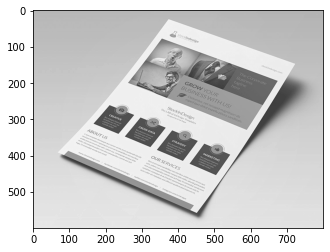

In [ ]:
%time gray_cv = cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2GRAY)
plt.imshow(gray_cv, cmap='gray')
plt.show()

* **Numpy**

CPU times: user 18.8 ms, sys: 8.17 ms, total: 26.9 ms
Wall time: 27.8 ms


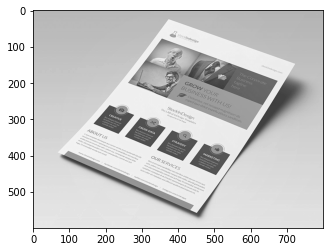

In [ ]:
%time gray_np = convert_RGB_Gray_np(img)
plt.imshow(gray_np, cmap='gray')
plt.show()

* **@jit**

In [ ]:
%time gray_py = convert_RGB_Gray_py(img)

CPU times: user 428 ms, sys: 17.1 ms, total: 445 ms
Wall time: 479 ms


CPU times: user 2.63 ms, sys: 0 ns, total: 2.63 ms
Wall time: 2.92 ms


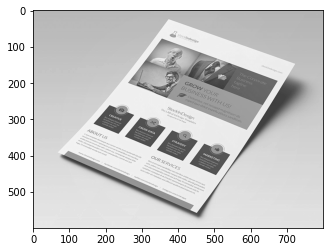

In [ ]:
%time gray_py = convert_RGB_Gray_py(img)
plt.imshow(gray_py, cmap='gray')
plt.show()

* **So sánh** kết quả và thời gian thực thi của ba cách

| Thời gian (ms) | Cách tiếp cận |
|:---:|:---|
||openCV|
|| Numpy|
|| Python loop|
|| Python loop cached (@jit)|

In [ ]:
print("OpenCV vs Numpy: ", np.abs(gray_cv - gray_np).mean())
print("OpenCV vs Python (@jit): ", np.abs(gray_cv - gray_py).mean())
print("Python (@jit) vs Numpy: ", np.abs(gray_py - gray_np).mean())

OpenCV vs Numpy:  0.046807056458338304
OpenCV vs Python (@jit):  0.046807056458338304
Python (@jit) vs Numpy:  0.0


#### **Nhận xét**
* Sự khác nhau giữa ảnh xám của OpenCV với ảnh xám của Python (@jit) và Numpy là do có sự khác biệt ở hệ số của ba kênh màu (RGB).
* Về thời gian chạy:
    * OpenCV luôn nhanh nhất vì bản chất code của OpenCV là C/C++....

### Xác định biên cạnh bằng Sobel

* **OpenCV**

CPU times: user 31.7 ms, sys: 9.83 ms, total: 41.6 ms
Wall time: 63.2 ms


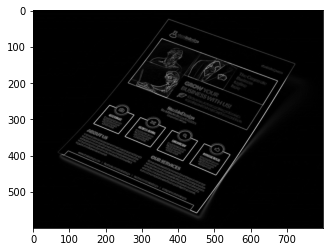

In [ ]:
%time edge_sobel_cv, angle_cv = edgeGradient_cv(gray_cv)
plt.imshow(edge_sobel_cv, cmap='gray')
plt.show()

* **Numpy**

CPU times: user 37.1 ms, sys: 7.84 ms, total: 44.9 ms
Wall time: 49.1 ms


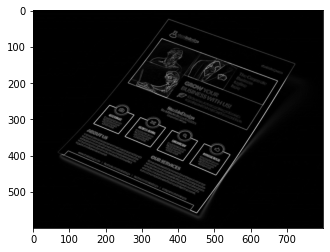

In [ ]:
%time edge_sobel_np, angle_np = edgeGradient_np(gray_np, sobel_x_kernel, sobel_y_kernel)
plt.imshow(edge_sobel_np, cmap='gray')
plt.show()

* **@jit**

In [ ]:
%time edge_sobel_py, angle_py = edgeGradient_py(gray_py, sobel_x_kernel,sobel_y_kernel)

CPU times: user 12.2 s, sys: 109 ms, total: 12.4 s
Wall time: 15.7 s


CPU times: user 56.2 ms, sys: 5.98 ms, total: 62.2 ms
Wall time: 61 ms


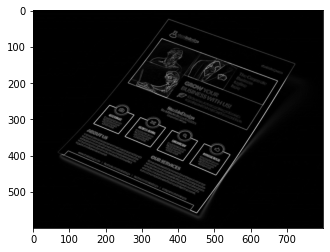

In [ ]:
%time edge_sobel_py, angle_py = edgeGradient_py(gray_py, sobel_x_kernel, sobel_y_kernel)
plt.imshow(edge_sobel_py, cmap='gray')
plt.show()

* **So sánh** kết quả và thời gian thực thi của ba cách

| Thời gian (ms) | Cách tiếp cận |
|:---:|:---|
||openCV|
|| Scipy + Numpy|
|| Python loop|
|| Python loop cached (@jit)|

In [ ]:
print('Edge sobel:')
print("OpenCV vs Numpy: ", np.abs(edge_sobel_cv - edge_sobel_np).mean())
print("OpenCV vs Python (@jit): ", np.abs(edge_sobel_cv - edge_sobel_py).mean())
print("Python (@jit) vs Numpy: ", np.abs(edge_sobel_py - edge_sobel_np).mean())

Edge sobel:
OpenCV vs Numpy:  0.184758464118767
OpenCV vs Python (@jit):  0.184758464118767
Python (@jit) vs Numpy:  3.9072096614268616e-16


* Xác định viền bằng OpenCV

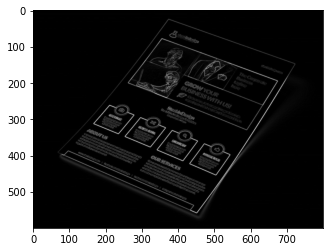

In [ ]:
edge_cv = edge_sobel_cv.copy()
edge_cv = (edge_cv - edge_cv.min()) / (edge_cv.max() - edge_cv.min()) * 255
edge_cv = edge_cv.astype(np.uint8)
plt.imshow(edge_cv, cmap='gray')
plt.show()

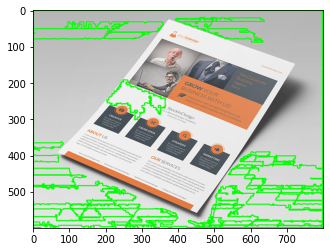

In [ ]:
contours,hierarchy = cv2.findContours(edge_cv.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

contours = sorted(contours, key = lambda x:cv2.contourArea(x), reverse = True)
output = img.copy()

cv2.drawContours(output,  contours[:5], -1, (0, 255, 0), 2)
plt.imshow(output)
plt.show()

#### **Nhận xét**
Vì kết quả của việc xác định biên cạnh bằng Sobel không thể đưa ra cạnh có độ dày mỏng nhất và cũng không được lọc để loại bỏ các chi tiết nhỏ $→$ kết quả khi dùng hàm tìm biên không đúng $→$ nhóm sẽ sử dụng phương pháp Canny để xác định biên cạnh.

### Phát hiện biên cạnh

#### **Giảm nhiễu**

* **OpenCV**

CPU times: user 2.92 ms, sys: 998 µs, total: 3.92 ms
Wall time: 4.13 ms


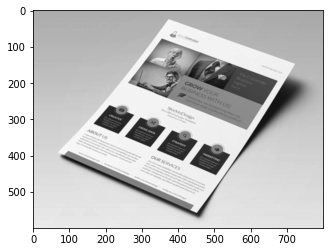

In [ ]:
%time gaussianBlur_cv = cv2.GaussianBlur(gray_cv, (gau_kernel_size, gau_kernel_size), cv2.BORDER_DEFAULT)
plt.imshow(gaussianBlur_cv, cmap='gray')
plt.show()

* **Numpy**

CPU times: user 11.6 ms, sys: 983 µs, total: 12.6 ms
Wall time: 13.4 ms


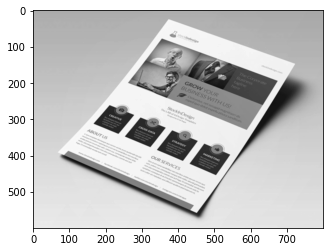

In [ ]:
%time gaussianBlur_np = convolutionLayer_np(gray_np, gau_kernel)
plt.imshow(gaussianBlur_np, cmap='gray')
plt.show()

* **@jit**

In [ ]:
%time gaussianBlur_py = convolutionLayer_py(gray_py, gau_kernel)

CPU times: user 338 ms, sys: 2.03 ms, total: 340 ms
Wall time: 341 ms


CPU times: user 14.5 ms, sys: 1.94 ms, total: 16.5 ms
Wall time: 17.3 ms


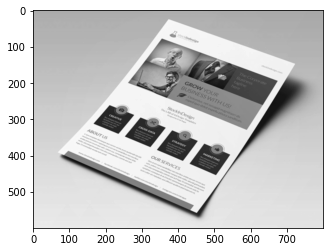

In [ ]:
%time gaussianBlur_py = convolutionLayer_py(gray_py, gau_kernel)
plt.imshow(gaussianBlur_py, cmap='gray')
plt.show()

* **So sánh** kết quả và thời gian thực thi của ba cách

| Thời gian (ms) | Cách tiếp cận |
|:---:|:---|
||openCV|
|| Scipy + Numpy|
|| Python loop|
|| Python loop cached (@jit)|

In [ ]:
print("OpenCV vs Numpy: ", np.abs(gaussianBlur_cv - gaussianBlur_np).mean())
print("OpenCV vs Python (@jit): ", np.abs(gaussianBlur_cv - gaussianBlur_py).mean())
print("Python (@jit) vs Numpy: ", np.abs(gaussianBlur_py - gaussianBlur_np).mean())

OpenCV vs Numpy:  41.566159368752054
OpenCV vs Python (@jit):  41.566159368752054
Python (@jit) vs Numpy:  0.0


##### **Nhận xét**

#### **Tính Gradient và hướng Gradient**

* **OpenCV**

CPU times: user 29.8 ms, sys: 7.95 ms, total: 37.7 ms
Wall time: 37.1 ms


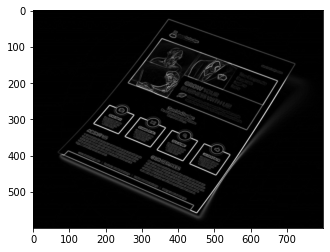

In [ ]:
%time edge_sobel_cv, angle_cv = edgeGradient_cv(gaussianBlur_cv)
plt.imshow(edge_sobel_cv, cmap='gray')
plt.show()

* **Numpy**

CPU times: user 52.2 ms, sys: 4.04 ms, total: 56.3 ms
Wall time: 58.3 ms


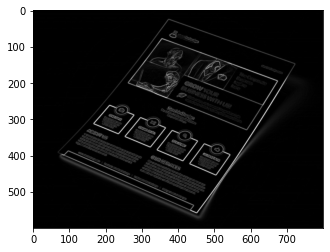

In [ ]:
%time edge_sobel_np, angle_np = edgeGradient_np(gaussianBlur_np, sobel_x_kernel, sobel_y_kernel)
plt.imshow(edge_sobel_np, cmap='gray')
plt.show()

* **@jit**

In [ ]:
%time edge_sobel_py, angle_py = edgeGradient_py(gaussianBlur_py, sobel_x_kernel, sobel_y_kernel)

CPU times: user 58.3 ms, sys: 3.01 ms, total: 61.3 ms
Wall time: 61.7 ms


CPU times: user 53.9 ms, sys: 6.01 ms, total: 59.9 ms
Wall time: 57.4 ms


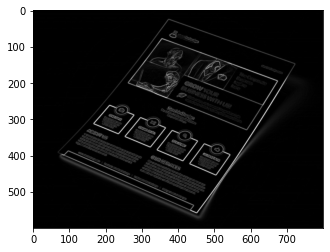

In [ ]:
%time edge_sobel_py, angle_py = edgeGradient_py(gaussianBlur_py, sobel_x_kernel, sobel_y_kernel)
plt.imshow(edge_sobel_py, cmap='gray')
plt.show()

* **So sánh** kết quả và thời gian thực thi của ba cách

| Thời gian (ms) | Cách tiếp cận |
|:---:|:---|
||openCV|
|| Scipy + Numpy|
|| Python loop|
|| Python loop cached (@jit)|

In [ ]:
print('Edge sobel:')
print("OpenCV vs Numpy: ", np.abs(edge_sobel_cv - edge_sobel_np).mean())
print("OpenCV vs Python (@jit): ", np.abs(edge_sobel_cv - edge_sobel_py).mean())
print("Python (@jit) vs Numpy: ", np.abs(edge_sobel_py - edge_sobel_np).mean())

Edge sobel:
OpenCV vs Numpy:  4.48688676397453
OpenCV vs Python (@jit):  4.48688676397453
Python (@jit) vs Numpy:  2.8402597114507434e-16


##### **Nhận xét**

#### **Non-Maximum Suppression**

* **@jit**

In [ ]:
%time non_max_sup_py = nonMaxSuppression(edge_sobel_py, angle_py)

CPU times: user 508 ms, sys: 9.16 ms, total: 517 ms
Wall time: 517 ms


In [ ]:
%time non_max_sup_py = nonMaxSuppression(edge_sobel_py, angle_py)

CPU times: user 3.02 ms, sys: 957 µs, total: 3.97 ms
Wall time: 4.06 ms


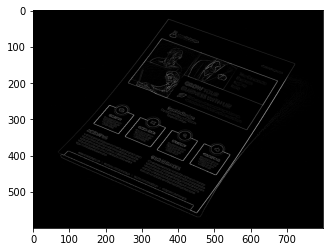

In [ ]:
plt.imshow(non_max_sup_py, cmap='gray')
plt.show()

* **So sánh** kết quả và thời gian thực thi của ba cách

| Thời gian (ms) | Cách tiếp cận |
|:---:|:---|
||openCV|
|| Scipy + Numpy|
|| Python loop|
|| Python loop cached (@jit)|

In [ ]:
print('Non max suppression:')
# print("OpenCV vs Numpy: ", np.abs(non_max_sup_cv - non_max_sup_np).mean())
# print("OpenCV vs Python (@jit): ", np.abs(non_max_sup_cv - non_max_sup_py).mean())
# print("Python (@jit) vs Numpy: ", np.abs(non_max_sup_py - non_max_sup_np).mean())

Non max suppression:


##### **Nhận xét**

#### **Lọc ngưỡng**

* **@jit**

In [ ]:
%time canny_edge_py = hysteresisThreshold(non_max_sup_py, 0.05, 0.15)

CPU times: user 1.06 s, sys: 12 ms, total: 1.07 s
Wall time: 1.07 s


In [ ]:
%time canny_edge_py = hysteresisThreshold(non_max_sup_py, 0.05, 0.15)
canny_edge_py = canny_edge_py.astype(np.uint8)

CPU times: user 2.93 ms, sys: 951 µs, total: 3.88 ms
Wall time: 4.44 ms


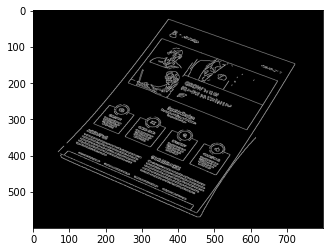

In [ ]:
plt.imshow(canny_edge_py, cmap='gray')
plt.show()

* **So sánh** kết quả và thời gian thực thi của ba cách

| Thời gian (ms) | Cách tiếp cận |
|:---:|:---|
||openCV|
|| Scipy + Numpy|
|| Python loop|
|| Python loop cached (@jit)|

##### **Nhận xét**

#### **Dùng hàm Canny của OpenCV**

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


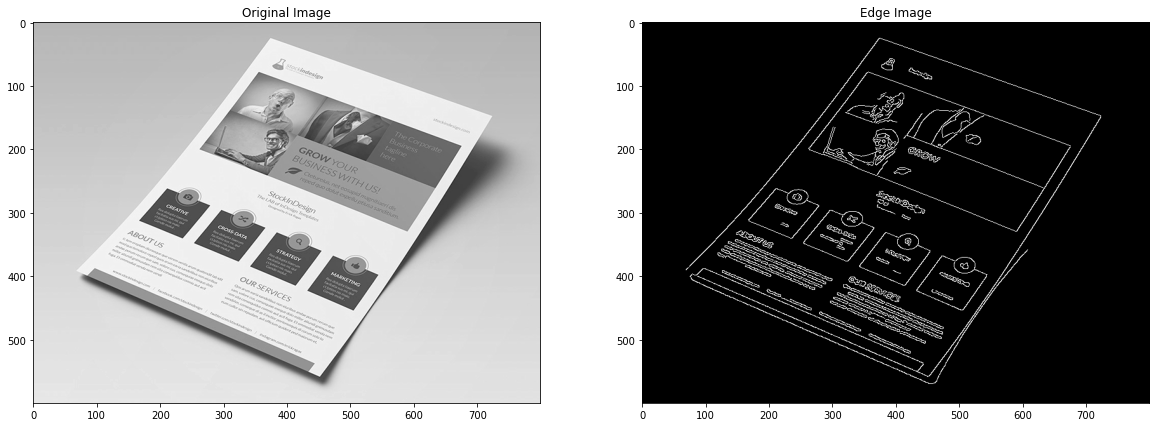

In [ ]:
%time 
canny_edge_cv = cv2.Canny(gaussianBlur_cv,100,200)

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(gray_cv,cmap = 'gray');
axis[0].set_title('Original Image');
axis[1].imshow(canny_edge_cv,cmap = 'gray');
axis[1].set_title('Edge Image');

* **So sánh** kết quả và thời gian thực thi của ba cách

| Thời gian (ms) | Cách tiếp cận |
|:---:|:---|
||openCV|
|| Scipy + Numpy|
|| Python loop|
|| Python loop cached (@jit)|

In [ ]:
print('Canny:')
# print("OpenCV vs Numpy: ", np.abs(canny_edge_cv - canny_edge_np).mean())
print("OpenCV vs Python (@jit): ", np.abs(canny_edge_cv - canny_edge_py).mean())
# print("Python (@jit) vs Numpy: ", np.abs(canny_edge_py - canny_edge_np).mean())

Canny:
OpenCV vs Python (@jit):  0.5812458333333334


### Tìm viền ảnh

* **OpenCV**

In [ ]:
%time 
cnts = cv2.findContours(canny_edge_cv.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = lambda x:cv2.arcLength(x,True), reverse = True)

# cnts = sorted(cnts, key = cv2.contourArea, reverse = True)
# for c in cnts:
#     peri = cv2.arcLength(c, True)
#     approx = cv2.approxPolyDP(c, 0.01 * peri, True)
#     print(len(approx))
#     break

#     if len(approx) == 4:
#         four_vertices_cnts = approx
#         cnt = c
#         break

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


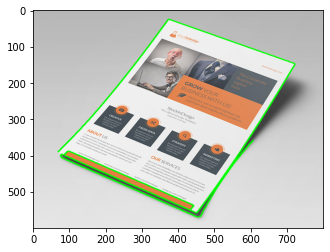

In [ ]:
output = img.copy()
cv2.drawContours(output, cnts, 0, (0, 255, 0), 2)
plt.imshow(output)
plt.show()

### Xác định 4 đỉnh của ảnh

In [ ]:
choosen_cnt = cnts[0].squeeze()

max_x, max_y = choosen_cnt[:,0].max(),choosen_cnt[:,1].max()
min_x, min_y = choosen_cnt[:,0].min(), choosen_cnt[:,1].min()

b_can, t_can = choosen_cnt[choosen_cnt[:,0] == max_x], choosen_cnt[choosen_cnt[:,0] == min_x]
l_can, r_can = choosen_cnt[choosen_cnt[:,1] == min_y], choosen_cnt[choosen_cnt[:,1] == max_y]

t = get_pos(t_can, min_y, max_y, 1)
l = get_pos(l_can, min_x, max_x, 0)
r = get_pos(r_can, min_x, max_x, 0)
b = get_pos(b_can, min_y, max_y, 1)

In [ ]:
four_vertices_cnts = []

get_4_vertices(t, l, r, b, four_vertices_cnts)
four_vertices_cnts = order_points_py(np.array(four_vertices_cnts)) #tl, tr, br, bl

In [ ]:
four_vertices_cnts

array([[375,  25],
       [ 69, 390],
       [458, 569],
       [722, 150]], dtype=int32)

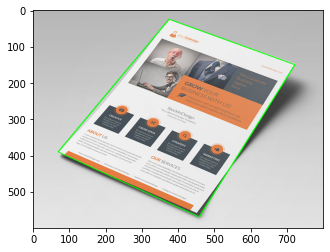

In [ ]:
output = img.copy()
cv2.drawContours(output, [four_vertices_cnts], 0, (0, 255, 0), 2)
plt.imshow(output)
plt.show()

#### **Nhận xét**


### Tìm ma trận Homography

In [ ]:
tl, tr, br, bl = four_vertices_cnts

widthA = ((br[0] - bl[0]) ** 2 + (br[1] - bl[1]) ** 2) ** 0.5
widthB = ((tr[0] - tl[0]) ** 2 + (tr[1] - tl[1]) ** 2) ** 0.5

maxWidth = int(widthA) if int(widthA) > int(widthB) else int(widthB)

heightA = ((tr[0] - br[0]) ** 2 + (tr[1] - br[1]) ** 2) ** 0.5
heightB = ((tl[0] - bl[0]) ** 2 + (tl[1] - bl[1]) ** 2) ** 0.5

maxHeight = int(heightA) if int(heightA) > int(heightB) else int(heightB)

In [ ]:
n_four_vertices_cnts = [n_tl, n_tr, n_br, n_bl] = np.array([[0,0], 
                                                   [0, maxWidth-1], 
                                                   [maxHeight-1, maxWidth - 1], 
                                                   [maxHeight - 1, 0]], dtype = 'float32')

In [ ]:
H = cv2.getPerspectiveTransform(four_vertices_cnts.astype('float32'), n_four_vertices_cnts)

### Map tọa độ mới cho ảnh

* **OpenCV**

CPU times: user 5.53 ms, sys: 17 µs, total: 5.55 ms
Wall time: 8.8 ms


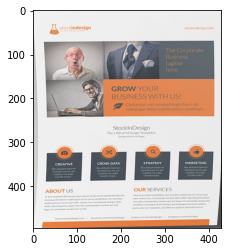

In [ ]:
# ratio = img.shape[0] / 1000
%time warped = four_point_transform(img, four_vertices_cnts)
plt.imshow(warped)
plt.show()

* **@jit**

In [ ]:
new_img = np.zeros((maxWidth, maxHeight, img.shape[-1]))
%time map_pos_homo(img, new_img, H, maxWidth, maxHeight)

CPU times: user 463 ms, sys: 5.08 ms, total: 468 ms
Wall time: 464 ms


In [ ]:
%time map_pos_homo(img, new_img, H, maxWidth, maxHeight)
new_img = new_img.astype(int)

CPU times: user 14.9 ms, sys: 0 ns, total: 14.9 ms
Wall time: 15.3 ms


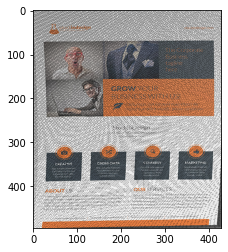

In [ ]:
plt.imshow(new_img)
plt.show()

#### **Nhận xét**
* Hình ảnh kết quả bị nhiễu, khó có thể nhìn rõ ảnh.
* Nhóm vẫn chưa rõ nguyên nhân gì dẫn tới ảnh đầu ra bị nhiễu như vậy.

## Tổng hợp và phân tích cho việc song song

### Viết phần tuần tự vào file python

In [ ]:
%%writefile sequential.py
import numpy as np
from numba import *
from PIL import *
from PIL import Image
import requests
from io import BytesIO
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
import math

from skimage.filters import threshold_local

#from google.colab.patches import cv2_imshow
import imutils

import warnings
warnings.filterwarnings('ignore')

import time

img_path = 'poster.png'
img = np.asarray(Image.open(img_path))

@jit(cache=True)
def convert_RGB_Gray_py(img):
    gray = np.zeros((img.shape[0],img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            gray[i,j] = img[i,j,0] * 0.2989  + img[i,j,1] * 0.5870 + img[i,j,2] * 0.1141
    
    return gray

@jit(cache=True)
def convolutionLayer_py(img, kernel):
    img_out = np.zeros(img.shape)
    rows, cols = img.shape
    rows_k, cols_k = kernel.shape
    for r in range(rows):
        for c in range(cols):
            out = 0
            for r_k in range(rows_k):
                for c_k in range(cols_k):
                    in_r = r - rows_k//2 + r_k;
                    in_c = c - cols_k//2 + c_k;
                    in_r = min(max(0, in_r), rows - 1);
                    in_c = min(max(0, in_c), cols - 1);
                    out += kernel[r_k,c_k] * img[in_r,in_c];
            img_out[r,c] = out
    return img_out

@jit(cache=True)
def matrixElementWise(mat1, mat2 = None, op='*', is_scalar = False):
    out_mat = np.zeros(mat1.shape)
    if is_scalar:
        if op == '+':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] + mat2        
        else:
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] * mat2
    else:
        if op == '+':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] + mat2[i,j]
        elif op == 'sqrt':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] ** 0.5
        elif op == 'abs':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = abs(mat1[i,j])
        elif op == 'arctan2':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = math.atan2(mat1[i,j], mat2[i,j])
        else:
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] * mat2[i,j]
    
    return out_mat

def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

gau_kernel_size = 3
gau_kernel = gaussian_kernel(gau_kernel_size)

sobel_x_kernel, sobel_y_kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], np.float32), np.array([[1,2,1],[0,0,0],[-1,-2,-1]], np.float32)

@jit(cache=True)
def edgeGradient_py(img, sobel_x_kernel, sobel_y_kernel):
    sobel_x = convolutionLayer_py(img,sobel_x_kernel)
    sobel_y = convolutionLayer_py(img,sobel_y_kernel)
    
    edge_sobel = matrixElementWise(
        matrixElementWise(
            matrixElementWise(sobel_x,sobel_x), 
            matrixElementWise(sobel_y,sobel_y), 
            op='+'),
        op='sqrt')
    
    #convert radian value to degree
    angle = matrixElementWise(
        matrixElementWise(
            sobel_y, 
            sobel_x, 
            op='arctan2'),
        (180 / np.pi),
        is_scalar=True)
    
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            if angle[r,c] < 0:
                angle[r,c] += 180
                    
    return edge_sobel, angle

@jit(cache=True)
def nonMaxSuppression(img, angle):
    Z = np.zeros(img.shape, np.int32)

    for r in range(1, img.shape[0]-1):
        for c in range(1, img.shape[1]-1):
            q, t = 255, 255
            
            if 0 <= angle[r,c] < 22.5 or 180 >= angle[r,c] >= 157.5:
                q, t = img[r, c+1], img[r, c-1]
            elif 67.5 > angle[r,c] >= 22.5:
                q, t = img[r+1, c-1], img[r-1, c+1]
            elif 112.5 > angle[r,c] >= 67.5:
                q, t = img[r+1, c], img[r-1, c]
            elif 157.5 > angle[r,c] >= 112.5:
                q, t = img[r-1, c-1], img[r+1, c+1]
            
            if img[r,c] >=q and img[r,c] >=t:
                Z[r,c] = img[r,c]
            else:
                Z[r,c] = 0
    return Z

@jit(cache=True)
def hysteresisThreshold(img, min_thres, max_thres):

    canny_mask = np.zeros(img.shape, np.int32)
    max_val = img.max() * max_thres
    min_val = max_val * min_thres
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y,x] > max_val:
                canny_mask[y,x] = 255
            elif img[y,x] > min_val:
                is_edge = False
                for i in range(max(0, y-1), min(img.shape[0], y+2)):
                    for j in range(max(0, x-1), min(img.shape[1], x+2)):
                        if img[i,j] > max_val:
                            is_edge = True
                            canny_mask[y,x] = 255
                            break
                    if is_edge:
                        break
    return canny_mask

@jit(cache=True)
def get_pos (lst_can, min, max, pos = 0):
    if len(lst_can[(lst_can[:,pos] == min) | (lst_can[:,pos] == max)]) == 0:
        ans1 = lst_can[lst_can[:,pos] == lst_can[:,pos].max()]
        return ans1[0], -1
    else:
        if  len(lst_can[(lst_can[:,pos] == min) | (lst_can[:,pos] == max)]) == 2:
            ans1 = lst_can[(lst_can[:,pos] == min)]
            ans2 = lst_can[(lst_can[:,pos] == max)]
            return ans1[0], ans2[0]
        else:
            if  len(lst_can[(lst_can[:,pos] == max)]) == 1:
                ans2 = lst_can[(lst_can[:,pos] == max)]
                return ans2[0], -1
            else:
                ans2 = lst_can[(lst_can[:,pos] == min)]
                return ans2[0], -1

def get_points(xy, lst):
    if xy[1] == -1:
        lst.append(xy[0])
    else:
        lst.extend(xy)

def get_4_vertices(t, l, r, b, lst_v):
    lst = []

    get_points(list(t), lst)
    get_points(list(l), lst)
    get_points(list(r), lst)
    get_points(list(b), lst)

    for i in range(len(lst)):
        flag = False
        for j in range(len(lst_v)):
            comp = lst[i] == lst_v[j]
            if comp.any():
                flag = True
        if not flag:
            lst_v.append(lst[i])

@jit(cache = True)
def get_l_r(lst, pts, isTop = True):
    l = []
    for i in lst:
        for v in pts:
            if i == v[0]:
                l.append(v)
    if l[0][1] < l[1][1]:
        l, r = l[0], l[1]
    else:
        l, r = l[1], l[0]
    if isTop:
        return l, r
    else:
        return r, l

@jit(cache=True)
def order_points_py(pts):
    t, b = sorted(pts[:, 0])[:2], sorted(pts[:, 0])[2:]

    order_vertices = []
    order_vertices.extend(list(get_l_r(t,pts)))
    order_vertices.extend(list(get_l_r(b,pts, False)))

    return np.array(order_vertices)

@jit(cache = True)
def map_pos_homo(img, new_img, H, w, h):
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            x = int((H[0,0] * c + H[0,1] * r + H[0,2]) / (H[2,0] * c + H[2,1] * r + H[2,2]))
            y = int((H[1,0] * c + H[1,1] * r + H[1,2]) / (H[2,0] * c + H[2,1] * r + H[2,2]))
            if 0 <= y < w and 0 <= x < h:
                new_img[y, x] = img[r, c]

@jit(cache = True)
def enhance_img_1_py(img, gau_kernel, sobel_x_kernel, sobel_y_kernel):
    gray = convert_RGB_Gray_py(img)

    gaussianBlur = convolutionLayer_py(gray, gau_kernel)
    edge_sobel, angle = edgeGradient_py(gaussianBlur, sobel_x_kernel, sobel_y_kernel)
    non_max_sup = nonMaxSuppression(edge_sobel, angle)
    canny_edge = hysteresisThreshold(non_max_sup, 0.05, 0.15)
    canny_edge = canny_edge.astype(np.uint8)

    return canny_edge

def enhance_img_2(img):
    cnts, _ = cv2.findContours(img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key = lambda x:cv2.arcLength(x,True), reverse = True)
    cnts = cnts[0].squeeze()

    max_x, max_y = cnts[:,0].max(),cnts[:,1].max()
    min_x, min_y = cnts[:,0].min(), cnts[:,1].min()

    b_can, t_can = cnts[cnts[:,0] == max_x], cnts[cnts[:,0] == min_x]
    l_can, r_can = cnts[cnts[:,1] == min_y], cnts[cnts[:,1] == max_y]

    t = get_pos(t_can, min_y, max_y, 1)
    l = get_pos(l_can, min_x, max_x, 0)
    r = get_pos(r_can, min_x, max_x, 0)
    b = get_pos(b_can, min_y, max_y, 1)
    four_vertices_cnts = []

    get_4_vertices(t, l, r, b, four_vertices_cnts)
    tl, tr, br, bl = four_vertices_cnts = order_points_py(np.array(four_vertices_cnts))

    widthA = ((br[0] - bl[0]) ** 2 + (br[1] - bl[1]) ** 2) ** 0.5
    widthB = ((tr[0] - tl[0]) ** 2 + (tr[1] - tl[1]) ** 2) ** 0.5

    maxWidth = int(widthA) if int(widthA) > int(widthB) else int(widthB)

    heightA = ((tr[0] - br[0]) ** 2 + (tr[1] - br[1]) ** 2) ** 0.5
    heightB = ((tl[0] - bl[0]) ** 2 + (tl[1] - bl[1]) ** 2) ** 0.5

    maxHeight = int(heightA) if int(heightA) > int(heightB) else int(heightB)

    n_four_vertices_cnts = np.array([[0,0], 
                                    [0, maxWidth], 
                                    [maxHeight, maxWidth], 
                                    [maxHeight, 0]], dtype = 'float32')
    
    H = cv2.getPerspectiveTransform(four_vertices_cnts.astype('float32'), n_four_vertices_cnts)

    return H, maxWidth, maxHeight

@jit(cache = True)
def enhance_img_3_py(img, H, width, height):
    new_img = np.zeros((width, height, 3)) if len(img.shape) == 3 else np.zeros((width, height))
    map_pos_homo(img, new_img, H, width, height)
    new_img = new_img.astype(int)
    
    return new_img

s = time.time()
step_1 = enhance_img_1_py(img, gau_kernel, sobel_x_kernel, sobel_y_kernel)
H, width, height = enhance_img_2(step_1)
step_3 = enhance_img_3_py(img, H, width, height)
e = time.time()
print("Time processing: ", (e-s)*1000, "ms")

s = time.time()
step_1 = enhance_img_1_py(img, gau_kernel, sobel_x_kernel, sobel_y_kernel)
H, width, height = enhance_img_2(step_1)
step_3 = enhance_img_3_py(img, H, width, height)
e = time.time()
print("Time processing cached: ", (e-s)*1000, "ms")

plt.imshow(step_3)
plt.show()


Writing sequential.py


In [ ]:
# !python sequential.py

### Tổng hợp hàm tuần tự cho các bước

In [ ]:
@jit(cache = True)
def enhance_img_1_py(img, gau_kernel, sobel_x_kernel, sobel_y_kernel):
    gray = convert_RGB_Gray_py(img)

    gaussianBlur = convolutionLayer_py(gray, gau_kernel)
    edge_sobel, angle = edgeGradient_py(gaussianBlur, sobel_x_kernel, sobel_y_kernel)
    non_max_sup = nonMaxSuppression(edge_sobel, angle)
    canny_edge = hysteresisThreshold(non_max_sup, 0.05, 0.15)
    canny_edge = canny_edge.astype(np.uint8)

    return canny_edge

def enhance_img_2(img):
    cnts, _ = cv2.findContours(img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key = lambda x:cv2.arcLength(x,True), reverse = True)
    cnts = cnts[0].squeeze()

    max_x, max_y = cnts[:,0].max(),cnts[:,1].max()
    min_x, min_y = cnts[:,0].min(), cnts[:,1].min()

    b_can, t_can = cnts[cnts[:,0] == max_x], cnts[cnts[:,0] == min_x]
    l_can, r_can = cnts[cnts[:,1] == min_y], cnts[cnts[:,1] == max_y]

    t = get_pos(t_can, min_y, max_y, 1)
    l = get_pos(l_can, min_x, max_x, 0)
    r = get_pos(r_can, min_x, max_x, 0)
    b = get_pos(b_can, min_y, max_y, 1)
    four_vertices_cnts = []

    get_4_vertices(t, l, r, b, four_vertices_cnts)
    tl, tr, br, bl = four_vertices_cnts = order_points_py(np.array(four_vertices_cnts))

    widthA = ((br[0] - bl[0]) ** 2 + (br[1] - bl[1]) ** 2) ** 0.5
    widthB = ((tr[0] - tl[0]) ** 2 + (tr[1] - tl[1]) ** 2) ** 0.5

    maxWidth = int(widthA) if int(widthA) > int(widthB) else int(widthB)

    heightA = ((tr[0] - br[0]) ** 2 + (tr[1] - br[1]) ** 2) ** 0.5
    heightB = ((tl[0] - bl[0]) ** 2 + (tl[1] - bl[1]) ** 2) ** 0.5

    maxHeight = int(heightA) if int(heightA) > int(heightB) else int(heightB)

    n_four_vertices_cnts = np.array([[0,0], 
                                    [0, maxWidth], 
                                    [maxHeight, maxWidth], 
                                    [maxHeight, 0]], dtype = 'float32')
    
    H = cv2.getPerspectiveTransform(four_vertices_cnts.astype('float32'), n_four_vertices_cnts)

    return H, maxWidth, maxHeight

@jit(cache = True)
def enhance_img_3_py(img, H, width, height):
    new_img = np.zeros((width, height, 3)) if len(img.shape) == 3 else np.zeros((width, height))
    map_pos_homo(img, new_img, H, width, height)
    new_img = new_img.astype(int)
    
    return new_img

In [ ]:
%time step_1 = enhance_img_1_py(img, gau_kernel, sobel_x_kernel, sobel_y_kernel)
%time H, width, height = enhance_img_2(step_1)
%time step_3 = enhance_img_3_py(img, H, width, height)

CPU times: user 220 ms, sys: 8.94 ms, total: 229 ms
Wall time: 237 ms
CPU times: user 7.12 ms, sys: 1.01 ms, total: 8.12 ms
Wall time: 8.05 ms
CPU times: user 402 ms, sys: 4.09 ms, total: 406 ms
Wall time: 414 ms


In [ ]:
%time step_1 = enhance_img_1_py(img, gau_kernel, sobel_x_kernel, sobel_y_kernel)
%time H, width, height = enhance_img_2(step_1)
%time step_3 = enhance_img_3_py(img, H, width, height)

CPU times: user 71.6 ms, sys: 4.99 ms, total: 76.6 ms
Wall time: 80.7 ms
CPU times: user 5.31 ms, sys: 979 µs, total: 6.29 ms
Wall time: 4.66 ms
CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 14.2 ms


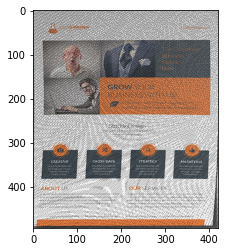

In [ ]:
plt.imshow(step_3)
plt.show()